# Experiment transforms
Somehow similar to the filters API, the transforms are objects that aim to "transform" the experiment object to a new experiment object.

Again, the returned value should always a new experiment, this allows chaining and pipelining of transforms.

Similar to how filters are applied using the *filter* methods, the transform API is applied using the **apply** method.

Examples of transforms are listed in this notebook/chapter.

In [1]:
%load_ext autoreload
%autoreload 2

#Load our data
from omicexperiment.experiment.microbiome import MicrobiomeExperiment

mapping = "example_map.tsv"
biom = "example_fungal.biom"
tax = "blast_tax_assignments.txt"

exp = MicrobiomeExperiment(biom, mapping,tax)

In [2]:
exp.counts_df

,sample0,sample1,sample2,1234,9876
2f328e48f4252bbade0dd7f66b0d5bf1b09617dd,0,2,0,0,225872
ae0ddda08027454fdb5db77c96b94691b8274cdd,0,91911,100428,2,1
8f52abc02aed2ce6c63be04570a7e609f9cdac5f,0,21,0,133138,0
3cb3c2347cdbe128b645e432f4dcbca702e0e8e3,0,0,0,0,0
8e9a3b9a9d91e86f21da1bd57b8ae4486c78bbe0,86870,0,0,0,0


In [3]:
exp.mapping_df

,#SampleID,BarcodeSequence,LinkerPrimerSequence,Description,patient_id,group,asthma,vas,amplicon_conc
#SampleID,,,,,,,,,
sample0,sample0,ACTGAGCG,AAAA,sample0,132,CRSsNP,0,49,4.3
sample1,sample1,AAGAGGCA,AAAA,sample1,315,CRSwNP,1,43,2.3
sample2,sample2,ATCTCAGG,AAAA,sample2,742,CRSsNP,0,23,3.2
1234,1234,ATGCGCAG,AAAA,1234,927,control,1,87,1.0
9876,9876,TAGGCATG,AAAA,9876,538,CRSwNP,1,12,1.3


## The apply function
The apply function can process three different types of parameters:
1. The first type of parameter is to pass a Transform object (or class).

2. The second type of parameter is to pass a function (which accepts a pandas DataFrame, intended here to be the experiment's counts_df). The reason for the decision to make this type of function accept a dataframe, rather than an OmicExperiment object is to make the apply functionality compatible with various pandas and numpy aggregate functions like sum, mean etc.

3. The third type of parameter is a list of Transform objects.

### The Relative Abundance Transform

In [4]:
from omicexperiment.transforms.general import RelativeAbundance
exp.apply(RelativeAbundance) #note how it returns a new experiment

In [5]:
exp.apply(RelativeAbundance).counts_df #peak into the transformed data

,sample0,sample1,sample2,1234,9876
2f328e48f4252bbade0dd7f66b0d5bf1b09617dd,0,0.002175,0,0.000000,99.999557
ae0ddda08027454fdb5db77c96b94691b8274cdd,0,99.974982,100,0.001502,0.000443
8f52abc02aed2ce6c63be04570a7e609f9cdac5f,0,0.022842,0,99.998498,0.000000
3cb3c2347cdbe128b645e432f4dcbca702e0e8e3,0,0.000000,0,0.000000,0.000000
8e9a3b9a9d91e86f21da1bd57b8ae4486c78bbe0,100,0.000000,0,0.000000,0.000000


### The Rarefaction Transform
A rarefaction transform rarefies our experiment to a desired cutoff.
All samples below this cutoff are discarded from the counts dataframe.

In [6]:
from omicexperiment.transforms.general import Rarefaction
exp.apply(Rarefaction(90000)).counts_df

,sample1,sample2,1234,9876
2f328e48f4252bbade0dd7f66b0d5bf1b09617dd,4,0,0,90000
8f52abc02aed2ce6c63be04570a7e609f9cdac5f,23,0,89999,0
ae0ddda08027454fdb5db77c96b94691b8274cdd,89973,90000,1,0


In [7]:
#a shorthand on the MicrobiomeExperiment object -- the rarefy method
exp.rarefy(90000).counts_df

,sample1,sample2,1234,9876
2f328e48f4252bbade0dd7f66b0d5bf1b09617dd,2,0,0,90000
8f52abc02aed2ce6c63be04570a7e609f9cdac5f,17,0,89999,0
ae0ddda08027454fdb5db77c96b94691b8274cdd,89981,90000,1,0


As previously explained, the rarefy function is rather simplistic at this stage. It may need the implementation of an extra parameter which allows taking the number of randomizations to run, and produce a final rarefied dataframe which is the average of all the randomized ones.

Example API:

    exp.apply(Rarefaction(n=90000, num_randomizations=50)).counts_df

(TODO)

### Applying a list of Transforms in sequence
Passing in a list which contains transforms objects/classes chains the transforms in sequence on our experiment.

In [8]:
exp.apply([Rarefaction(90000), RelativeAbundance]).counts_df

,sample1,sample2,1234,9876
2f328e48f4252bbade0dd7f66b0d5bf1b09617dd,0.004444,0,0.000000,100
8f52abc02aed2ce6c63be04570a7e609f9cdac5f,0.023333,0,99.998889,0
ae0ddda08027454fdb5db77c96b94691b8274cdd,99.972222,100,0.001111,0


Another very basic transform is the number of unique observations in each sample.
This is essentially the _"Number of Observed OTUs"_, or when used for species, can be described as _"species richness"_.

In [9]:
#%matplotlib inline
from omicexperiment.transforms.general import NumberUniqueObs
exp.apply(NumberUniqueObs).counts_df

,sample0,sample1,sample2,1234,9876
number_unique_obs,1,3,1,2,2


*Note how when we implement a Transform, we try to follow the convention of samples being in the columns rather than the rows (Take a look at the source code!)*

### Applying a numpy aggregate function
Passing in a function object (for example, numpy's sum or mean functions) to apply can be though of as equivalent to the following apply operation on the counts_df:

    DataFrame( experiment.counts_df.apply(func) )
    
Also available is the axis parameter to pass to the apply function of the counts_df (Default axis=0 i.e. columns):

    DataFrame( experiment.counts_df.apply(func, axis=axis) )

In [10]:
import numpy as np
exp.apply(np.mean).counts_df
#Note that a transpose() is done on the DataFrame in the inside of
#the apply method, such that sample names remain as columns.

,sample0,sample1,sample2,1234,9876
0,17374,18386.8,20085.6,26628,45174.6


## Rarefaction curves are implemented as a transform
Rarefaction curves is a very common transformation for microbiome amplicon studies and is utilized widely in the software package qiime.

In omicexperiment, it is implemented as a transform which takes three parameters as follows:
1. The rarefaction curve cutoff level. (Any sample with lower count than this cutoff will be dropped.)
2. The 'step': from 0 to the cutoff. For example, a cutoff value of 1000 and a step of 100 will rarefy at levels 0,100,200,300...,900,1000.
3. The Transform to apply: the transform will be applied at each rarefaction level

The RarefactionCurve Transform applies runs the transformation at each level until the cutoff, thus producing data points for the rarefaction curves.

The end result is demonstrated below. In the example below, we run the "Number of Unique Observations Transform" (i.e. observed_otus, or richness if species) on each level of the curve.

In [11]:
from omicexperiment.transforms.general import RarefactionCurve
curve_df = exp.apply(RarefactionCurve(10000, 1000, NumberUniqueObs)).counts_df

In [12]:
curve_df

,sample0,sample1,sample2,1234,9876
0,0,0,0,0,0
1000,1,1,1,1,1
2000,1,1,1,1,1
3000,1,2,1,2,1
4000,1,2,1,1,1
5000,1,2,1,1,1
6000,1,2,1,1,1
7000,1,2,1,1,1
8000,1,2,1,1,1
9000,1,3,1,1,1


For the sake of fun (and science!), you will find that we can very easily, using minimal code, plot this dataframe as an actual rarefaction curves plot.

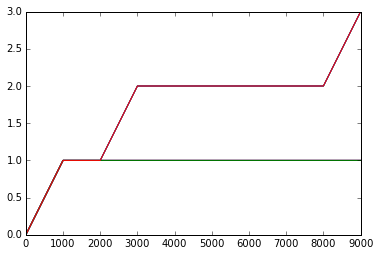

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
for sample in curve_df:
    plt.plot(curve_df.index, curve_df['sample0'])
    plt.plot(curve_df.index, curve_df['sample1'])

Not a very elegant curve for this example dataset, but you get the point!

### Taxonomy transforms (TODO)
Here, we will be implementing various taxonomy-related transforms.

The most important of these are **diversity functions**.

Most likely, this is going to depend on scikit-bio diversity package. (see http://scikit-bio.org/docs/latest/diversity.html)

The API can thus be imagined, a diversity function implemented as a Transform that can be passed to the RarefactionCurve transform allows easy charting of .